## Install, Import, Load Model

In [1]:
!pip install lucid>=0.2.3
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import scipy.ndimage as nd

from google.colab import files

import lucid.modelzoo.vision_models as models
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
                                                       
from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
from lucid.optvis.objectives import wrap_objective

import lucid.optvis.transform as transform
from lucid.misc.io.reading import read
import time


tf.test.is_gpu_available()
model = vision_models.InceptionV1_caffe_Places365()
model.load_graphdef()
model.layers
print(model.layers)
print("finished.. continue to next code box")


TensorFlow 1.x selected.


W1019 22:58:19.911328 139739555301248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/writing.py:62: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W1019 22:58:19.913388 139739555301248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/writing.py:70: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W1019 22:58:21.687447 139739555301248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/loading.py:72: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



[Layer (belonging to InceptionV1_caffe_Places365) <conv1_7x7_s2/conv1_7x7_s2: 64> ([set(['conv'])]), Layer (belonging to InceptionV1_caffe_Places365) <conv2_3x3_reduce/conv2_3x3_reduce: 64> ([set(['conv'])]), Layer (belonging to InceptionV1_caffe_Places365) <conv2_3x3/conv2_3x3: 192> ([set(['conv'])]), Layer (belonging to InceptionV1_caffe_Places365) <inception_3a_output: 256> ([set(['conv'])]), Layer (belonging to InceptionV1_caffe_Places365) <inception_3b_output: 480> ([set(['conv'])]), Layer (belonging to InceptionV1_caffe_Places365) <inception_4a_output: 512> ([set(['conv'])]), Layer (belonging to InceptionV1_caffe_Places365) <inception_4b_output: 512> ([set(['conv'])]), Layer (belonging to InceptionV1_caffe_Places365) <inception_4c_output: 512> ([set(['conv'])]), Layer (belonging to InceptionV1_caffe_Places365) <inception_4d_output: 528> ([set(['conv'])]), Layer (belonging to InceptionV1_caffe_Places365) <inception_4e_output: 832> ([set(['conv'])]), Layer (belonging to InceptionV1

In [2]:
!git clone https://github.com/lutherrr/Feature_inversion.git

Cloning into 'Feature_inversion'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


## Setup

In [3]:
def imgToModelSize(arr):

# --------------------------------------------------------------# 
#----- the W variable below sets the width of our outputs. -----#

  W = 356
# --------------------------------------------------------------# 



  w, h, _ = arr.shape
  s = float(W) / min(w,h)
  arr = nd.zoom(arr, [s, s, 1], mode="nearest")
  w, h, _ = arr.shape
  dw, dh = (w-W)//2, (h-W)//3
  return arr[dw:dw+W, dh:dh+W]
@objectives.wrap_objective
def dot_compare(layer, batch=1, cossim_pow=0):
  def inner(T):
    dot = tf.reduce_sum(T(layer)[batch] * T(layer)[0])
    mag = tf.sqrt(tf.reduce_sum(T(layer)[0]**2))
    cossim = dot/(1e-6 + mag)
    return dot * cossim ** cossim_pow
  return inner
def feature_inversion(img=None, layer=None, n_steps=512, cossim_pow=0.0):
  file_name = ''
  x = 0
  with tf.Graph().as_default(), tf.Session() as sess:
    img = imgToModelSize(img)
    x = x + 1
    
    objective = objectives.Objective.sum([
        1.0 * dot_compare(layer, cossim_pow=cossim_pow),
        objectives.blur_input_each_step(),
    ])

    t_input = tf.placeholder(tf.float32, img.shape)
    param_f = param.image(img.shape[0], decorrelate=True, fft=True, alpha=False)
    param_f = tf.stack([param_f[0], t_input])

    transforms = [
      transform.pad(8, mode='constant', constant_value=.5),
      transform.jitter(8),
      transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
      transform.random_rotate(range(-5, 5) + [0]*5),
      transform.jitter(2),
    ]

    T = render.make_vis_T(model, objective, param_f, transforms=transforms)
    loss, vis_op, t_image = T("loss"), T("vis_op"), T("input")

    tf.global_variables_initializer().run()
    for i in range(n_steps): _ = sess.run([vis_op], {t_input: img})

    result = t_image.eval(feed_dict={t_input: img})
    # set the file name with the path
    timestr = time.strftime("%Y%m%d-%H%M%S")
    
    file_name = '/content/2rc/AI-Maker-lucid-sneaker/lucid_sneaker_method_' + layer + '_image_' + '_cos_' + str(cossim_pow) + '_' + timestr + '.jpg'
    # save the graphic as a JPEG file
    save(result[0], file_name, quality=90)
    show(result[0])
  

# Designing with Neural Networks

Loading URL - /content/Feature_inversion/Images/worm2.jpg
Layer - inception_3b_output


W1019 22:59:19.079200 139739555301248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/param/spatial.py:54: The name tf.spectral.irfft2d is deprecated. Please use tf.signal.irfft2d instead.

W1019 22:59:19.101430 139739555301248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:223: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1019 22:59:19.102930 139739555301248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:241: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W1019 22:59:19.105441 139739555301248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/optvis/render.py:169: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.

W1019 22:59:19.114269 139739555301248 module_wrapper.py:


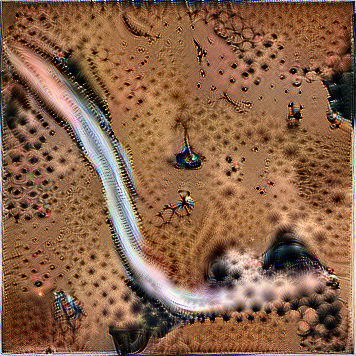


Loading URL - /content/Feature_inversion/Images/worm3.jpg
Layer - inception_3b_output



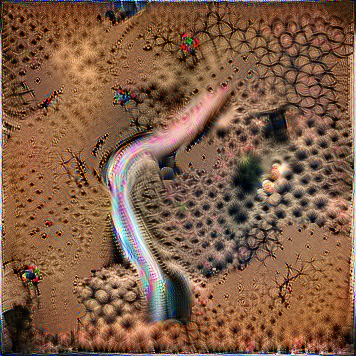


Loading URL - /content/Feature_inversion/Images/worm4.jpg
Layer - inception_3b_output



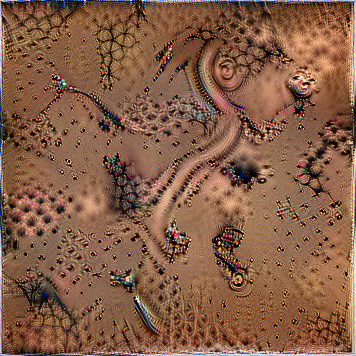

In [4]:
!mkdir /content/2rc

# --------------------------------------------------------------# 
#----- If You are working with a single image uncomment the # ---#
#----- from the begining each of the layers lines below, if you -#
#----- are creating a animation (multiple imgs) than uncomment---#
#----- the # from all lines except one to avoid output redundancy-#

layers =   [ 
#'inception_3a_output',
'inception_3b_output'
#'inception_4a_output',
#'inception_4b_output',
#'inception_4c_output',
#'inception_4d_output',
#'inception_4e_output',
#'inception_5a_output',
#'inception_5b_output'
]

# --------------------------------------------------------------# 
#---------- Below is the list of our images to work on ---------#

urls = [
        "/content/Feature_inversion/Images/worm2.jpg",
        "/content/Feature_inversion/Images/worm3.jpg",
        "/content/Feature_inversion/Images/worm4.jpg"
        ]

for url in urls:
    try:
        print('Loading URL - ' + url)
        img = load(url)
        #show(imgToModelSize(img))
        for layer in layers:
          print('Layer - ' + layer)
          feature_inversion(img, layer=layer)
          print ""
    except ValueError:
        print('********   Error Occurred on URL - ' + url + ' *************')
        pass

#!zip -r /content/lol2.zip /content/AI-Maker-lucid-sneaker